# Introduction

I requested 7.5 GB of memory, which has been appropriate. 

This notebook is for accessing MODIS data related to snow cover using the Python package earthaccess. We will be accessing the MOD10A1F which is a Level 3 product giving snow cover at 500m resolution. The "F" means that grid cells in MOD10A1 (original snow cover product) that are obscured by cloud cover are filled by retaining clear-sky views of the surface from previous days. More on this product can be found [here](https://nsidc.org/data/mod10a1f/versions/61). Much of this code and its documentation is adapted from the [data access tutorials](https://github.com/snowex-hackweek/website-2024/tree/main/book/tutorials/Data_access) from the 2024 UW Hackweek. 

----------------------------------------------------------------------------------------------------------
Notebook by Lexi Arlen

August 2024

In [1]:
# Querying
import earthaccess                                          # accessing earthdata
import json                                                 # defining the region from a geojson file   
from shapely.geometry import shape, GeometryCollection, Point, Polygon      # reformatting the geojson file
import pprint                                               # for nice printing
import logging                                              # for nice displaying of requests

# Processing
import xarray as xr                                         # for reading data
import rioxarray as rio                                     # geodata processing; gdal > rasterio > xarray > rioxarray
import numpy as np                                          # math

# Parsing
import os
import glob

# Plotting
# import hvplot.xarray                                      # create interactive plots of xarray objects
from geopandas import read_file                             # visualizing & plotting the shapefile 
import matplotlib.pyplot as plt                             # plots
import cartopy.crs as ccrs                                  # for geoaxes
import matplotlib.ticker as mticker                         # for tick marks & nice gridlines

%config InlineBackend.figure_format = 'png2x'               # higher resolution plots in notebook

# Authentication
To access data you need to log in with your earthdata account (you may search without logging in). If you don't have one, you can make an account [here](https://urs.earthdata.nasa.gov/users/new).

In [2]:
auth = earthaccess.login()

Enter your Earthdata Login username:  alexisarlen
Enter your Earthdata password:  ········


# Querying available datasets
Next, we'll search for datasets containing the MODIS snow cover product *MOD10A1F*. Even though we know which product we want, it can be helpful to print the metadata from the dataset query to be sure our data query has the right parameters

In [4]:
query = earthaccess.search_datasets(keyword="MOD10A1F",)

Print the first 10 lines from the query, comprising the first two datasets.

In [5]:
for collection in query[:10]:
    pprint.pprint(collection.summary(), sort_dicts=True, indent=4)
    print('')  # Add a space between collections for readability

{   'concept-id': 'C1646609734-NSIDC_ECS',
    'file-type': "[{'FormatType': 'Native', 'Format': 'HDF-EOS2', "
                 "'FormatDescription': 'HTTPS'}]",
    'get-data': [   'http://nsidc.org/daac/subscriptions.html',
                    'https://n5eil01u.ecs.nsidc.org/MOST/MOD10A1F.061/',
                    'https://search.earthdata.nasa.gov/search?q=MOD10A1F+V061',
                    'https://nsidc.org/data/data-access-tool/MOD10A1F/versions/61/'],
    'short-name': 'MOD10A1F',
    'version': '61'}

{   'concept-id': 'C2909924695-NSIDC_ECS',
    'file-type': "[{'FormatType': 'Native', 'Format': 'NetCDF', "
                 "'FormatDescription': 'HTTPS'}]",
    'get-data': [   'https://n5eil01u.ecs.nsidc.org/MOST/NSIDC-0791.001/',
                    'https://search.earthdata.nasa.gov/search?q=NSIDC-0791+V001',
                    'https://nsidc.org/data/data-access-tool/NSIDC-0791/versions/1/'],
    'short-name': 'NSIDC-0791',
    'version': '1'}



For each collection, `summary` returns a subset of fields from the collection metadata and Unified Metadata Model (UMM) entry.

- `concept-id` is an unique identifier for the collection that is composed of a alphanumeric code and the provider-id for the DAAC.
- `short-name` is the name of the dataset that appears on the dataset set landing page. For ICESat-2, `ShortNames` are generally how different products are referred to.
- `version` is the version of each collection.
- `file-type` gives information about the file format of the collection files.
- `get-data` is a collection of URL that can be used to access data, dataset landing pages, and tools.  

For _cloud-hosted_ data, there is additional information about the location of the S3 bucket that holds the data and where to get credentials to access the S3 buckets.  In general, you don't need to worry about this information because `earthaccess` handles S3 credentials for you.  Nevertheless it may be useful for troubleshooting. If you only want to search for data in the cloud, you add the additional argument `cloud_hosted=True`.

We see that the first dataset in the query is the one we're looking for. Now, lets access the data. 

# Accessing Data
Above is a query for datatsets, but now, we want to access data from a specefic region and time. The temporal range is identified with standard date strings, and latitude-longitude corners of a bounding box is specified.  Polygons and points, as well as shapefiles can also be specified.

For this project, we are looking at the 2020 water year for Grand Mesa, CO. A geojson file defining the region...

In [2]:
# Open a geojson of our area of interest
with open("./grand_mesa.geojson") as f:
    features = json.load(f)["features"]

grandmesa = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
grandmesa_gdf = read_file('grand_mesa.geojson')
grandmesa_gdf.explore()

### Parameters that go into the search_data function
**Data:**
- short_name = ''
- version = ''
- cloud_hosted = True/False
  
**Region:**
- bounding_box = (lon min, lat min, lon max, lat max)
- point = (lon, lat)

**Time frame:**
- temporal = ('yyyy-mm-dd', 'yyyy-mm-dd') start and end dates

**Other Parameters:**
- count = maximum number of returned results

For now, we'll get the set the bounding_box from the extent from the geojson file. I'm not sure what keyword to use if I wanted to preserve an irregular shape for the geojson file. Perhaps polygon? 

In [7]:
N = 260

results = earthaccess.search_data(
    short_name = 'MOD10A1F',
    version = '61',
    cloud_hosted = True,
    bounding_box = grandmesa.bounds,
    temporal = ('2020-10-01','2021-07-01'),
    count = N
)

Now, let's display every 60th file we've found.

In [8]:
for i, r in enumerate(results):
    if i % 60 == 0:
        display(r)

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-10-01T00:00:00.000Z', 'EndingDateTime': '2020-10-01T23:59:59.000Z'}}
Size(MB): 0.448476
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2020.10.01/MOD10A1F.A2020275.h09v05.061.2020347153118.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-11-30T00:00:00.000Z', 'EndingDateTime': '2020-11-30T23:59:59.000Z'}}
Size(MB): 1.29623
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2020.11.30/MOD10A1F.A2020335.h09v05.061.2020357070855.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-01-29T00:00:00.000Z', 'EndingDateTime': '2021-01-29T23:59:59.000Z'}}
Size(MB): 2.46029
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2021.01.29/MOD10A1F.A2021029.h09v05.061.2021040050739.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-03-30T00:00:00.000Z', 'EndingDateTime': '2021-03-30T23:59:59.000Z'}}
Size(MB): 1.37435
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2021.03.30/MOD10A1F.A2021089.h09v05.061.2021091050651.hdf']

Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}, {'Longitude': -104.256722414513, 'Latitude': 40.0742066197196}, {'Longitude': -117.486656023174, 'Latitude': 39.9999999964079}, {'Longitude': -103.835851753394, 'Latitude': 29.8360532722546}, {'Longitude': -92.131858571552, 'Latitude': 29.9009502428382}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-05-29T00:00:00.000Z', 'EndingDateTime': '2021-05-29T23:59:59.000Z'}}
Size(MB): 1.18295
Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2021.05.29/MOD10A1F.A2021149.h09v05.061.2021151045429.hdf']

Clicking on the image shoes that the more red, the larger percent snow in the given 500m pixel. We see that as time goes on, more snow accumulates, which makes sense as these images are ordered chronologically staring at the beginning of winter. 

The query I made required the data to be cloud hosted, but it seems like the data isn't. Maybe if there isn't any cloud hosted data, the search ignore the cloud_hosted demand. 

Because I don't think MODIS data can be accessed via the cloud, we will have to download the data. In the lines below, we will download every 10th image found into a folder called *data.* We will then upload this folder to CryoCloud. 

In [9]:
for i,r in enumerate(results): 
    if i % 10 == 0:
        earthaccess.download(r, "./data")
        date = r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'][:10]
        print(f'Downloading data from {date}')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

```{note}
If you like using `git add .` to commit changes, make sure to create a *.gitignore* file so that you don't commit the .hdf files on accident and slow down commits for other snowmelt-timing users. 

A gitignore file can be created from the command line. Type `nano .gitignore` to open a new file with the name .gitignore. Then, add in all the files you'd like to be ignored in the commit with a return between each file. To ignore all hdf files, type '*.hdf* into the file. Press Ctrl + X to exit, then Y to save your changes. Commit and push the .gitignore file. 
```

# Data processing & visualization
Now, we will read the data using rioxarray and plot it using matplotlib. First, we'll consider an example image to go through the basics of rioxarray, matplotlib, and cartopy.

With rioxarray, xarray can now be used to open MODIS data so long as the engine is specified as rasterio. Just importing rasterio without rioxarray will not allow you to use the rasterio engine to open MODIS data as an xarray dataset. 

In [29]:
ds = xr.open_dataset('MOD10A1F.A2020336.h09v05.061.2020357073222.hdf', engine = 'rasterio')

Let's print the dataset to see the coordinate system and the variables included. 

We see that x and y are in units of meters rather than latitude and longitude. We will want to correct this before plotting by reprojecting the data. The spatial_ref coordinate contains details about the data's current coordinate system. 

We see that in addition to the data we requested, the cloud gap filled (CGF) NDSI Snow Cover, we got a few other variables including the MOD10A1 product which contains no backfilling. By clicking the piece of paper icon next to each variable, more information about the data is provided including how the non-snow values are defined. 

In [30]:
ds

<xarray.Dataset> Size: 115MB
Dimensions:                  (band: 1, x: 2400, y: 2400)
Coordinates:
  * band                     (band) int64 8B 1
  * x                        (x) float64 19kB -1.001e+07 ... -8.896e+06
  * y                        (y) float64 19kB 4.448e+06 4.447e+06 ... 3.336e+06
    spatial_ref              int64 8B ...
Data variables:
    CGF_NDSI_Snow_Cover      (band, y, x) float32 23MB ...
    Cloud_Persistence        (band, y, x) float32 23MB ...
    Basic_QA                 (band, y, x) float32 23MB ...
    Algorithm_Flags_QA       (band, y, x) float32 23MB ...
    MOD10A1_NDSI_Snow_Cover  (band, y, x) float32 23MB ...
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:      12-2017
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR10A1F
    ALGORITHMPACKAGEVERSION:             1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SPSOPARAMETERS:                      none
    TileID:                              51009005
    Time Series Day:                     62
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174

ds.rio.reproject_match

In [32]:
ds_reprojected = ds.rio.reproject('EPSG:4326') # lat lon

In [33]:
ds_reprojected

<xarray.Dataset> Size: 79MB
Dimensions:                  (x: 3153, y: 1256, band: 1)
Coordinates:
  * x                        (x) float64 25kB -117.5 -117.5 ... -92.39 -92.38
  * y                        (y) float64 10kB 40.0 39.99 39.98 ... 30.01 30.0
  * band                     (band) int64 8B 1
    spatial_ref              int64 8B 0
Data variables:
    CGF_NDSI_Snow_Cover      (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Cloud_Persistence        (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Basic_QA                 (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Algorithm_Flags_QA       (band, y, x) float32 16MB nan 0.0 0.0 ... 64.0 64.0
    MOD10A1_NDSI_Snow_Cover  (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:      12-2017
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR10A1F
    ALGORITHMPACKAGEVERSION:             1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SPSOPARAMETERS:                      none
    TileID:                              51009005
    Time Series Day:                     62
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174

Observe that the CGF_NDSI_Snow_Cover variable has values greater than 100 to show where there is missing data, 201=no decision, 211=night, 237=inland water, 239=ocean, 250=cloud, 254=detector saturated, 255=fill. For our purposes, we will just set these to be nans. 

In [65]:
# Set all nan type values to 0
snow_cover_values = ds_reprojected['CGF_NDSI_Snow_Cover']
values_to_nan = [200, 201, 211, 237, 239, 250, 254, 255]
snow_cover_0_100 = snow_cover_values.where(~snow_cover_values.isin(values_to_nan), np.nan)

# Add the new variable to the dataset
ds_reprojected['snow_cover_0-100'] = snow_cover_0_100

Below, we'll plot the data. 

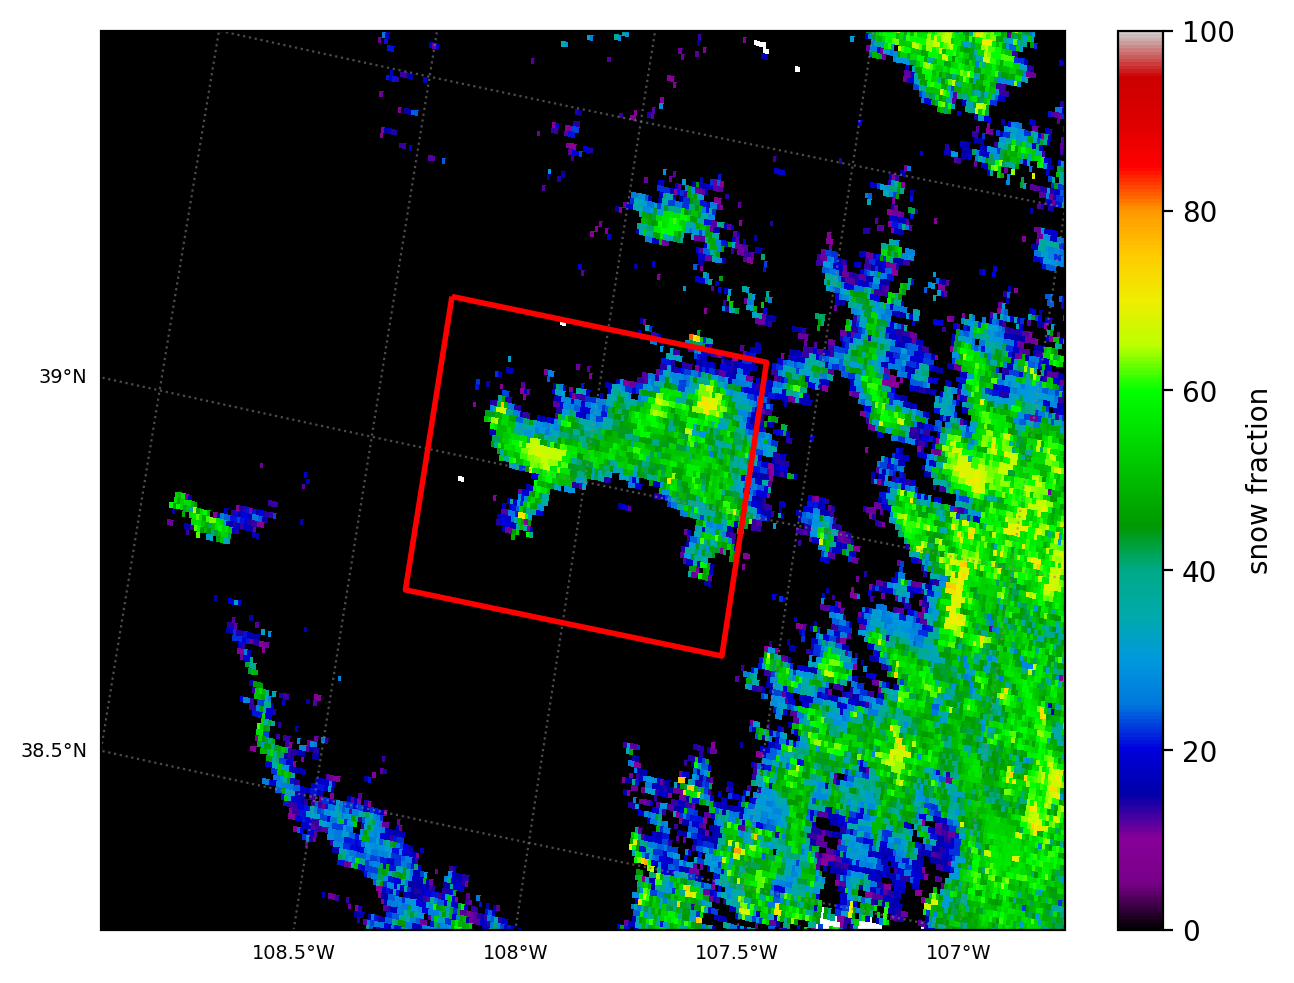

In [67]:
fig = plt.figure(layout = 'constrained')

# Format the geoaxes
map_extent = [-109, -107, 38.5, 39.5]
proj = ccrs.Orthographic(-90, 30)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(map_extent)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.6)
gl.xlocator = mticker.FixedLocator(np.linspace(-109, -107, 5))
gl.ylocator = mticker.FixedLocator(np.linspace(38, 40, 5))
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = {'size': 'x-small'}
gl.ylabel_style = {'size': 'x-small'}

# Plot the image data
cm = plt.pcolormesh(ds_reprojected['x'], ds_reprojected['y'], ds_reprojected['snow_cover_0-100'][0, :, :], 
                    vmin = 0, vmax = 100, cmap = 'nipy_spectral', transform = ccrs.PlateCarree())
plt.colorbar(cm, label = 'snow fraction')

# Plot the grandmesa shapefile
grandmesa_gdf.plot(ax=ax, edgecolor='red', lw = 2, facecolor='none', zorder = 12, transform = ccrs.PlateCarree())

plt.show()

# Preprocessing downloaded data. 

In [5]:
rootdir = 'data'
datasets = []
for fname in sorted(os.listdir(rootdir)):
    # Open the file
    fpath = os.path.join(rootdir, fname)
    ds = xr.open_dataset(fpath, engine = 'rasterio')
    
    # Reproject to latitude & longitude 
    reprojected_ds = ds.rio.reproject('EPSG:4326')
    ds.close()

    # Set all nan type values to 0
    snow_cover_values = reprojected_ds['CGF_NDSI_Snow_Cover']
    values_to_nan = [200, 201, 211, 237, 239, 250, 254, 255]
    snow_cover_0_100 = snow_cover_values.where(~snow_cover_values.isin(values_to_nan), np.nan)

    # Add the new variable to the dataset
    reprojected_ds['snow_cover_0-100'] = snow_cover_0_100

    # Create list of the reprojected datastets
    datasets.append(reprojected_ds)
    reprojected_ds.close()

# Save images to make a gif.

In [ ]:
for i in range(len(datasets)):
    # Format geoaxes and cartopy features
    fig = plt.figure(layout = 'constrained')
    map_extent = [-109, -107, 38.5, 39.5]
    proj = ccrs.Orthographic(-90, 30)
    ax = fig.add_subplot(111, projection=proj)
    ax.set_extent(map_extent)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.6)
    gl.xlocator = mticker.FixedLocator(np.linspace(-109, -107, 5))
    gl.ylocator = mticker.FixedLocator(np.linspace(38, 40, 5))
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 'x-small'}
    gl.ylabel_style = {'size': 'x-small'}
    
    # Plot the image data
    cm = plt.pcolormesh(datasets[i]['x'], datasets[i]['y'], datasets[i]['snow_cover_0-100'][0, :, :], 
                        cmap = 'nipy_spectral', transform = ccrs.PlateCarree(), vmin =0, vmax = 100)
    plt.colorbar(cm, label = 'snow fraction')
    
    # Plot the grandmesa shapefile
    grandmesa_gdf.plot(ax=ax, edgecolor='red', lw = 2, facecolor='none', zorder = 12, transform = ccrs.PlateCarree())
        
    
    title = datasets[i].RANGEBEGINNINGDATE
    plt.title(title)

    fig_title = os.path.join('pngs_for_gif', datasets[i].RANGEBEGINNINGDATE + '.png')
    
    plt.savefig(fig_title, dpi = 300)
    plt.close()


# Make time series for water year of 2020 for smaller region

In [7]:
# Open a geojson of our area of interest
with open("./sample_area.geojson") as f:
    features = json.load(f)["features"]
    #pol = geojson.load(f)

# Extract the polygon from the GeoJSON file
polygon = shape(features[0]['geometry'])

sample_area = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
sample_area_gdf = read_file('sample_area.geojson')

In [5]:
N = 365

results = earthaccess.search_data(
    short_name = 'MOD10A1F',
    version = '61',
    cloud_hosted = True,
    bounding_box = sample_area.bounds,
    temporal = ('2020-07-17','2020-09-30'),
    count = N
)

In [6]:
for r in results: 
    earthaccess.download(r, "./ts_data")
    date = r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'][:10]
    print(f'Downloading data from {date}')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
def mean_snow_cover_in_sample_area(ds, polygon):


    '''
    This is a function to load snow cover data and compute the mean snow cover in a 
    box. 
    '''

    # Create a mask array
    ys, xs = np.meshgrid(ds['y'], ds['x'])
    mask = np.array([[polygon.contains(Point(y, x)) for y in ys[0]] for x in xs[:,0]])

    # Broadcast the mask to the shape of the snow variable
    mask_xr = xr.DataArray(mask, dims=['x', 'y'], coords={'x': ds['x'], 'y': ds['y']})

    # Mask the sic data
    snow_masked = ds['snow_cover_0-100'].where(mask_xr)

    # Calculate the spatial mean while ignoring NaN values
    snow_mean = snow_masked.mean(dim=['x', 'y'], skipna=True)

    ds.close()

    return snow_mean

In [18]:
def preprocess_and_reproject_data(ds):
    # Reproject the dataset to EPSG:4326
    reproj = ds.rio.reproject('EPSG:4326')
    title = ds.RANGEBEGINNINGDATE
    ds.close()

    # Set all nan type values to 0 and filter for valid snow cover values
    snow_cover_values = reproj['CGF_NDSI_Snow_Cover']
    values_to_nan = [200, 201, 211, 237, 239, 250, 254, 255]
    snow_cover_0_100 = snow_cover_values.where(~snow_cover_values.isin(values_to_nan), 0)
    
    # Create a new xarray dataset with just 'snow_cover_0-100' and 'x', 'y' coordinates
    new_ds = xr.Dataset({
        'snow_cover_0-100': snow_cover_0_100
    }, coords={
        'x': reproj['x'],
        'y': reproj['y']
    })
    
    # Save the new dataset (optional)
    new_ds.to_netcdf(os.path.join('ts_data_preprocessed', title + '_snow_cover.nc')) 

In [19]:
rootdir = 'ts_data'
datasets = []
for fname in sorted(os.listdir(rootdir)):
    ds = xr.load_dataset(os.path.join('ts_data', fname), engine = 'rasterio')
    print(f'working on {fname}')
    preprocess_and_reproject_data(ds)               

working on MOD10A1F.A2019274.h09v05.061.2020312172718.hdf
working on MOD10A1F.A2019275.h09v05.061.2020312200930.hdf
working on MOD10A1F.A2019276.h09v05.061.2020312222553.hdf
working on MOD10A1F.A2019277.h09v05.061.2020313012420.hdf
working on MOD10A1F.A2019278.h09v05.061.2020313025218.hdf
working on MOD10A1F.A2019279.h09v05.061.2020313044745.hdf
working on MOD10A1F.A2019280.h09v05.061.2020313063545.hdf
working on MOD10A1F.A2019281.h09v05.061.2020313080905.hdf
working on MOD10A1F.A2019282.h09v05.061.2020313120422.hdf
working on MOD10A1F.A2019283.h09v05.061.2020313135423.hdf
working on MOD10A1F.A2019284.h09v05.061.2020313165317.hdf
working on MOD10A1F.A2019285.h09v05.061.2020313200323.hdf
working on MOD10A1F.A2019286.h09v05.061.2020313224156.hdf
working on MOD10A1F.A2019287.h09v05.061.2020314003315.hdf
working on MOD10A1F.A2019288.h09v05.061.2020314025926.hdf
working on MOD10A1F.A2019289.h09v05.061.2020314054400.hdf
working on MOD10A1F.A2019290.h09v05.061.2020314074647.hdf
working on MOD

Test `clip_box`.

In [4]:
ds_test = xr.load_dataset('ts_data_preprocessed/2019-10-04_snow_cover.nc', engine = 'rasterio')

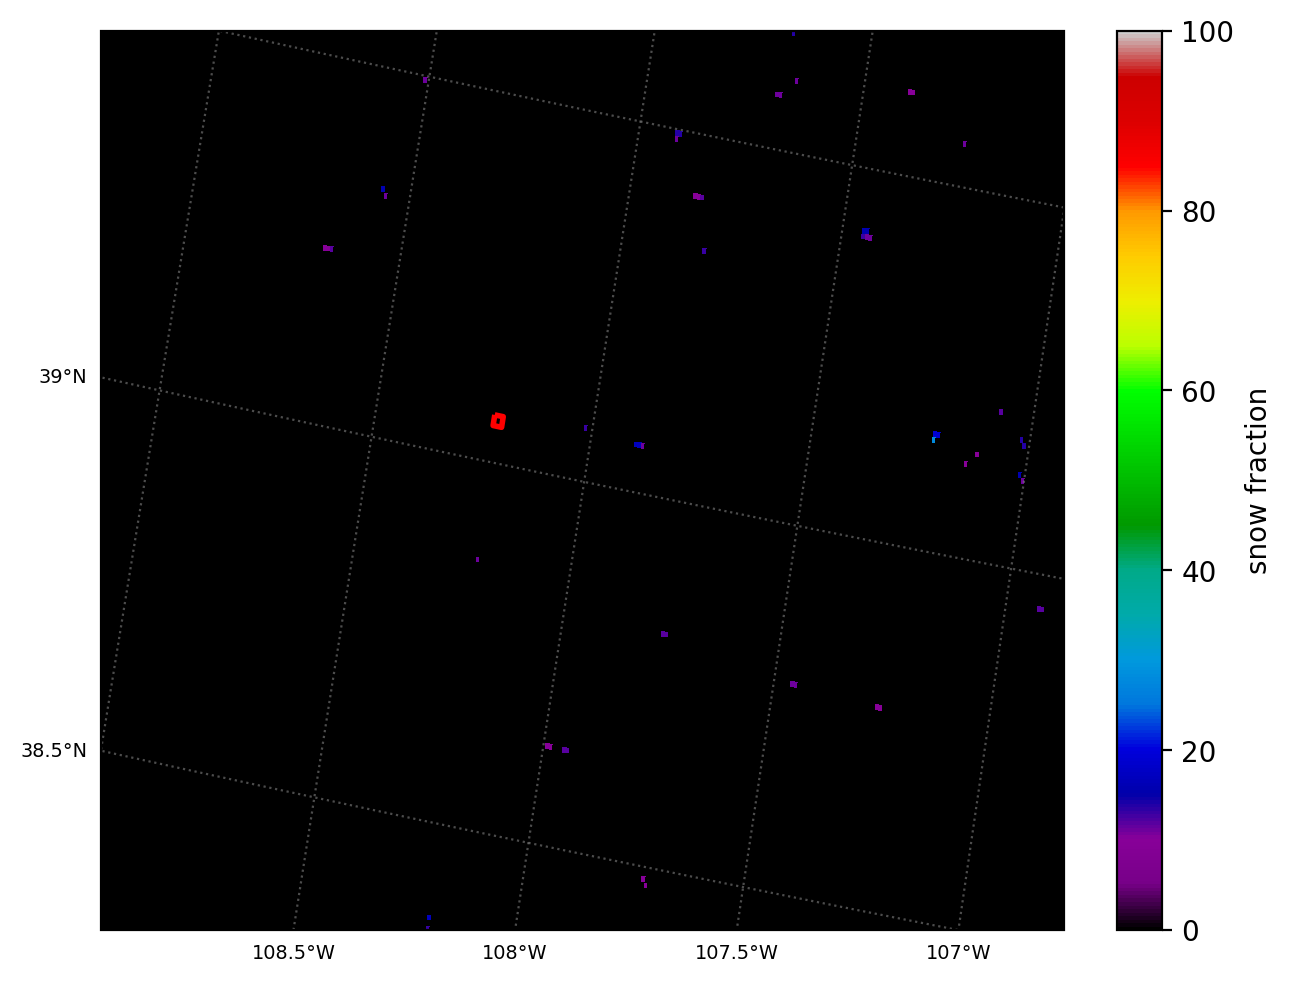

In [8]:
fig = plt.figure(layout = 'constrained')

# Format the geoaxes
map_extent = [-109, -107, 38.5, 39.5]
proj = ccrs.Orthographic(-90, 30)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(map_extent)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.6)
gl.xlocator = mticker.FixedLocator(np.linspace(-109, -107, 5))
gl.ylocator = mticker.FixedLocator(np.linspace(38, 40, 5))
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = {'size': 'x-small'}
gl.ylabel_style = {'size': 'x-small'}

# Plot the image data
cm = plt.pcolormesh(ds_test['x'], ds_test['y'], ds_test['snow_cover_0-100'][0, :, :], 
                    vmin = 0, vmax = 100, cmap = 'nipy_spectral', transform = ccrs.PlateCarree())
plt.colorbar(cm, label = 'snow fraction')

# Plot the grandmesa shapefile
sample_area_gdf.plot(ax=ax, edgecolor='red', lw = 2, facecolor='none', zorder = 12, transform = ccrs.PlateCarree())

plt.show()

In [19]:
minx, miny, maxx,maxy = sample_area.bounds
ds_test = ds_test.rio.write_crs("EPSG:4326")
ds_crop_test = ds_test.rio.clip_box(minx, miny, maxx, maxy)

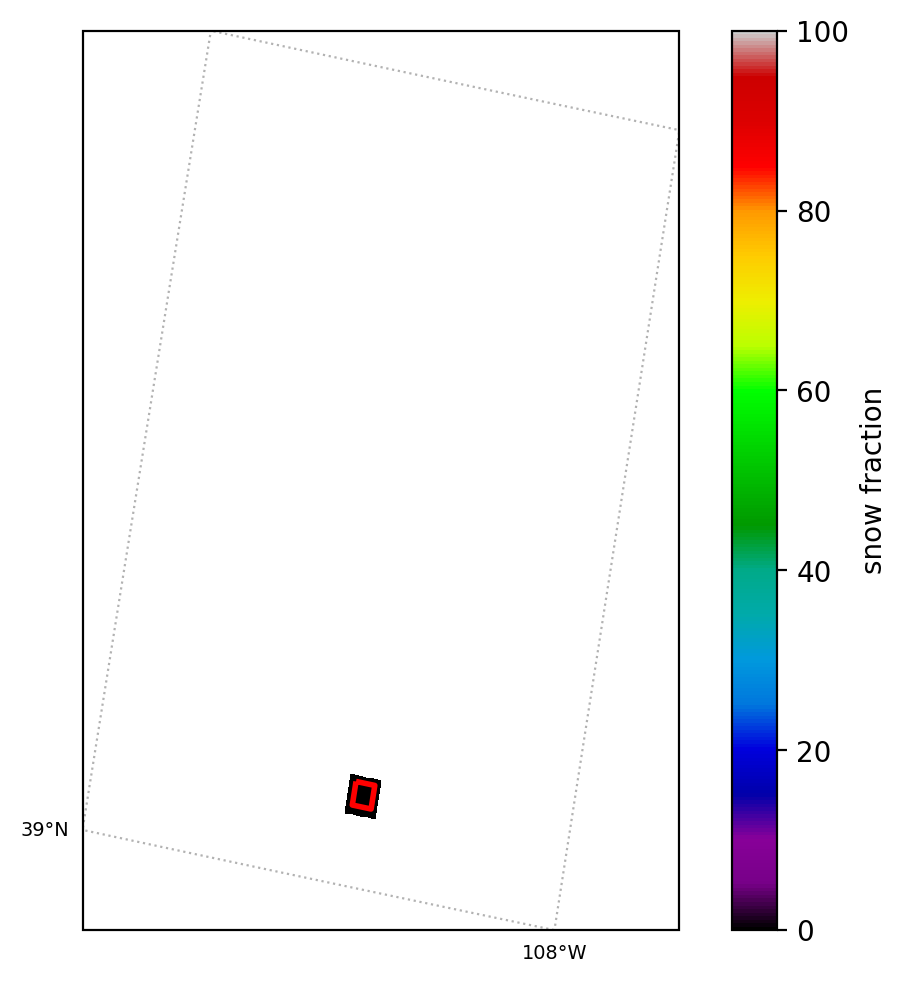

In [20]:
fig = plt.figure(layout = 'constrained')

# Format the geoaxes
map_extent = [-108.5, -108, 39, 39.5]
proj = ccrs.Orthographic(-90, 30)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(map_extent)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.6)
gl.xlocator = mticker.FixedLocator(np.linspace(-109, -107, 5))
gl.ylocator = mticker.FixedLocator(np.linspace(38, 40, 5))
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = {'size': 'x-small'}
gl.ylabel_style = {'size': 'x-small'}

# Plot the image data
cm = plt.pcolormesh(ds_crop_test['x'], ds_crop_test['y'], ds_crop_test['snow_cover_0-100'][0, :, :], 
                    vmin = 0, vmax = 100, cmap = 'nipy_spectral', transform = ccrs.PlateCarree())
plt.colorbar(cm, label = 'snow fraction')

# Plot the grandmesa shapefile
sample_area_gdf.plot(ax=ax, edgecolor='red', lw = 2, facecolor='none', zorder = 12, transform = ccrs.PlateCarree())

plt.show()

Okay, the above function works. The easiest way to get the time series would be to not reproject the data, but instead use a crs keyword in the `ds_test.rio.clip_box` function. Since we've already reprojected and dealt with nans, we'll just go from here...

In [25]:
means = []
filenames = sorted(glob.glob(os.path.join('ts_data_preprocessed', '*_cover.nc')))
for fname in filenames:
    ds = xr.load_dataset(fname, engine = 'rasterio')
    ds = ds.rio.write_crs("EPSG:4326")
    ds_crop = ds.rio.clip_box(minx, miny, maxx, maxy)
    snow_data = np.where(ds_crop['snow_cover_0-100'] < 0, np.nan, ds_crop['snow_cover_0-100'])# nans are -999 so we will make these actual nans
    mean_val = np.nanmean(snow_data) # take the mean
    means.append(mean_val)
    ds.close()
    ds_crop.close()

In [26]:
means = np.array(means)
np.save('mean_snow_cover_from_modis_2020WY.npy', means)

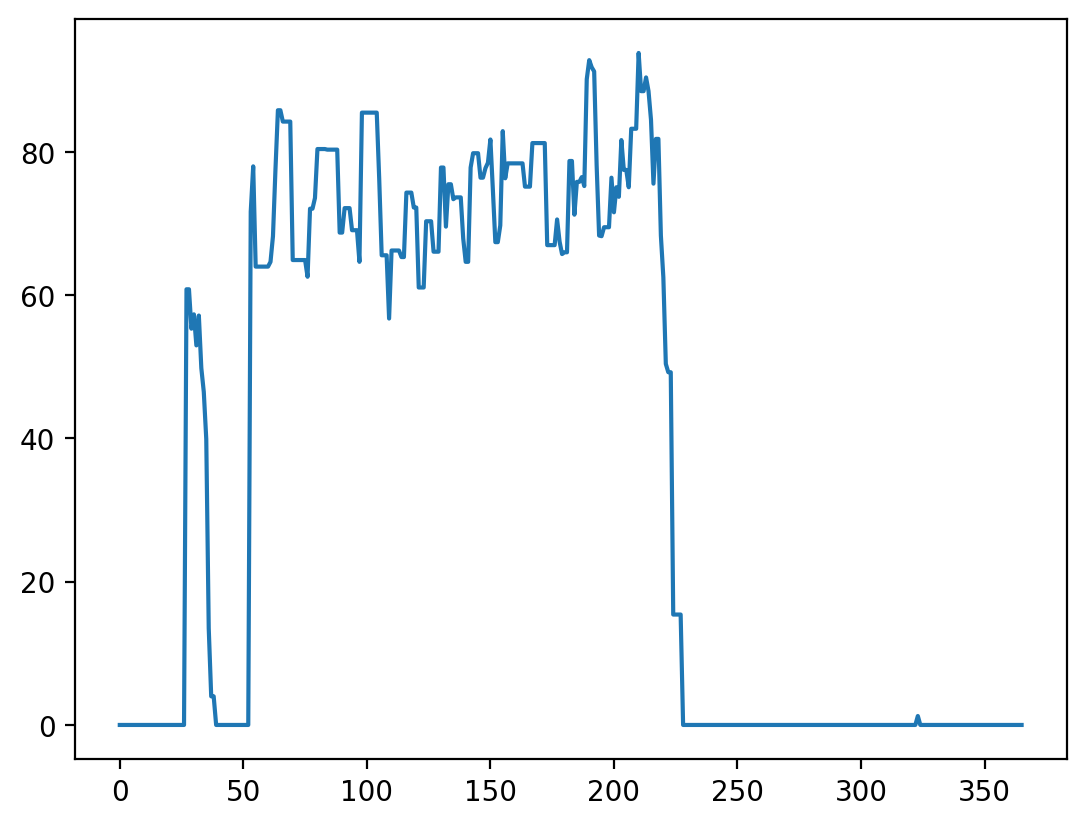

In [28]:
plt.plot(means)